# Recurrent Neural Network Assignment for my MS-DS 5511 Deep Learning Course

## Project Overview / Description

There are many "micro-blog" websites out there where people post statuses and updates in real time. One very popular one is Twitter where the posts are called "tweets." Additionally, many public organizations are interested in crowdsourcing notable events from these tweets because humans are great sensors for physical things in the world. This kaggle competition focusses on using tweets for the purpose of capturing disasters. However, sometimes people make hyperbolic tweets. The goal of this notebook is to correctly classify wheather tweets are about real disasters or not.

Furthermore, since this is an assignment for a course on Recurrent Neural Networks, we will be looking to use tensorflow to build a network. 


## Steps:
### 1. Gather Data
### 2. Perform EDA
### 3. Model Architecture 
### 4. Results and Analysis
### 5. Conclusion




## Step 1: Connect to GDrive and Kaggle!

First set some variables to make sure all the paths can be established. Then we grab our data in a consistent manner. This involves accessing the collab runtime file system, gdrive, and using kaggle's apis. 

Then download and unzip the files into your collab compute instance. Note for future: If using TPU then you need to load the data into Google Cloud storage. I ran out of energy to learn this part; I'm not too proud to say it. 

In [1]:
# Make sure you accept the competition terms first : https://www.kaggle.com/competitions/nlp-getting-started/data

# specify the folder you want to place the unzipped kaggle files and the competition name (most likely the url)
root = 'nlp_tweets'
competition_name = 'nlp-getting-started'

# look at the dataset on the kaggle website and fill in the below strings
train_folder = f"""{root}/{'train'}/"""
test_folder = f"""{root}/{'test'}/"""

In [2]:
import os
import subprocess
import shlex

# some helper functions 

# run shell commands 

def run_command(command):
  '''
  A function to run a shell process
  '''
  return subprocess.run(shlex.split(command), capture_output=True)

# record timestamps - when we walk away, we want to come back and know how long things took.
import time
def stamp(thing):
  '''
  A function to print the current time so we can see how long things take
  '''
  print(thing,"time =",time.strftime("%D:%H:%M:%S", time.localtime()))


In [3]:
# google drive stuff

# mount google drive connection and specify a path for the output.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

gdrive_path =  f"""/content/gdrive/MyDrive/MS-DS/Machine Learning - 5511/{root}/""" 

# upload the API token : kaggle.json file downloaded from kaggle account page
# you could put this kaggle.json file in your drive directly like it did 

kaggle_json_path = "/content/gdrive/MyDrive/MS-DS/Machine Learning - 5511/kaggle.json"
cmd_kaggle_json_path = '\ '.join(kaggle_json_path.split(' '))

# or uncomment the below 2 lines to do an upload

# from google.colab import files
# files.upload()

# kaggle doc link : https://www.kaggle.com/general/74235
# connect to kaggle and upload the api token - https://github.com/Kaggle/kaggle-api 
!pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp $cmd_kaggle_json_path ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/gdrive
rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:



stamp('start')
# download the zip file in this collab runtime
# !kaggle competitions download -c ${competition_name}
run_command(f"""kaggle competitions download -c {competition_name}""")


# unzip the file into a new folder
# !mkdir cancer_dataset
run_command(f"""mkdir {root}""")

# !unzip -q ${competition_name}.zip -d ${root}
run_command(f"""unzip -q {competition_name}.zip -d {root}""")

stamp('end')
print(f"""Successfully downloaded and unzipped kaggle dataset to {root}""")
print("Folders inside are:")
print(os.listdir(root))

start time = 06/05/23:12:42:21
end time = 06/05/23:12:42:23
Successfully downloaded and unzipped kaggle dataset to nlp_tweets
Folders inside are:
['train.csv', 'test.csv', 'sample_submission.csv']


In [5]:
import pandas as pd
import pickle
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)



from matplotlib import pyplot as plt

## Step 2 : Perform EDA

Let's do 3 basic steps:

1. See how many rows in our csv files?
2. What is the distribution of the training labels / targets?
3. What's in our csv files?



In [6]:
# read in the labels. This is a supervised learning problem so our train target classifications are known.
train = pd.read_csv(f"""{root}/train.csv""")

# how many rows are in the trains csv?
print(f"""We have {train.shape[0]} training rows in our csv data set""")

# make a df of our testing image names. Here we do the opposite of the above to build the id column
test = pd.read_csv(f"""{root}/test.csv""")

# how many testing images do we have?
print(f"""We also have {len(test)} test rows""")

We have 7613 training rows in our csv data set
We also have 3263 test rows


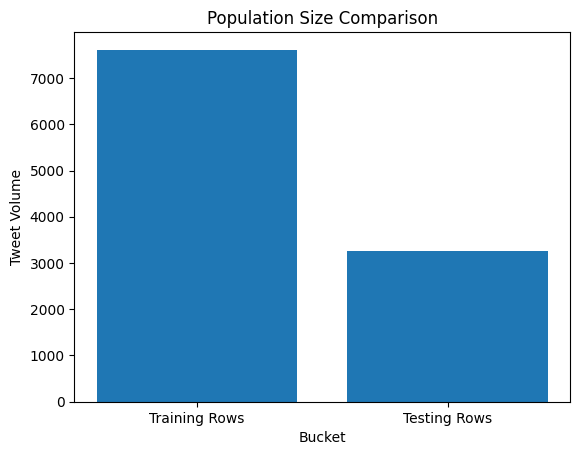

In [7]:
plt.bar(['Training Rows','Testing Rows'], [len(train),len(test)])
plt.title('Population Size Comparison')
plt.xlabel('Bucket')
plt.ylabel('Tweet Volume')
plt.show()

In [8]:
# Let's look at our csv of labels and :

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# let's take a quick peek at a summary of our training images details
print("Our training label csv is:")
train.info()

Our training label csv is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
# let's take a quick peek at a summary of our training images details
print("Our traintestinging label csv is:")
test.info()

Our traintestinging label csv is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [11]:
# we see that we have an id column - let's check if we have duplicate ids
print(train['id'].value_counts().head(2))
print(test['id'].value_counts().head(2))

1       1
7229    1
Name: id, dtype: int64
0       1
7293    1
Name: id, dtype: int64


In [12]:
# what percentage of our data is what classification?
print("Our label percentages are:")
train['target'].value_counts()/len(train)

Our label percentages are:


0    0.57034
1    0.42966
Name: target, dtype: float64

<Axes: ylabel='target'>

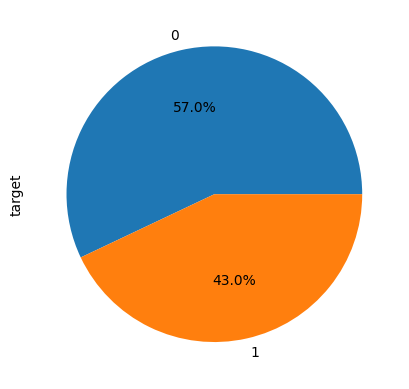

In [13]:
# let's see those numbers in a pie chart, yum!
(train['target'].value_counts()/len(train)).plot.pie(autopct='%1.1f%%')

In [14]:
# our final step is to do some prelim data formatting. In order to utilize tf, we need to convert from pandas series to numpy arrays

train_text = np.array(train['text']) 
train_label = np.array(train['target']) 
test_text = np.array(test['text'])


import tensorflow as tf
from tensorflow.keras import layers

train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text))


### EDA Summary

In the first 2 sections, we learned that we have simple csv files with our text. Our training set has ~7k tweets and our testing is ~3k tweets. Our training data is further split into hand classifications where ~43% of tweets are classified as relating to real disasters. We also see that we don;t have duplicate tweets in the raw csv files.

Next we have to decide upon and build an RNN. TBD on how we have to pre-process our tweets into ngrams / timestamps and how we will want to lemmatize and or tokenize. 

## Step 3 : Model Architecture 

Now that we have our data imported, we have to run it through a model. In our case we are including the encoding step inside the model architecture. In other cases and situations, the data transformation / pre-processing could be handeled in it's own model prior. 

Our general model will have a few steps. Each step might provide an opportunity for hyperparameter tuning. It's also important to note that this order is also generally representative of a more generic machine learning flow: 
1. Preprocess the text into a numerical representation
2. Construct and Compile a model with many layers
3. Fit our model with our training data
4. Predict the classification of our testing data
5. Analyze our results

For our assignment we are gojng to keep the preprocessing constant so that we can better compare the two basic RNN layers we learned in the lections.
1. Long Short-Term Memory (LSTM) 
2. Gated Recurrent Unit (GRU)

We will basically follow the example here and make small tweaks as we want : https://www.tensorflow.org/text/tutorials/text_classification_rnn. 

In [15]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
)

encoder.adapt(train_dataset.map(lambda text, label: text))


In [16]:
# helper function from tf reference
def plot_graphs(history, metric):
  plt.plot(history[metric])
  plt.plot(history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

  return


def view_model(model_history):

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plot_graphs(model_history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(model_history, 'loss')
  plt.ylim(0, None)

  return



# make a helper function to run and dave the results. 
# This helps so that we can run the models on GPU and setp away. When we come back we can use CPU to analyze the results

def run_save_model(model_obj,model_name,epochs, steps):

  stamp('start')
  model_results = model_obj.fit(train_text, train_label, epochs=epochs,
                    validation_split=0.15,
                    validation_steps=steps)
  print(model_obj.summary())
  stamp('end')

  model_obj.save(gdrive_path+model_name)

  with open(gdrive_path+model_name+'_results', 'wb') as file_pi:
      pickle.dump(model_results.history, file_pi)

  stamp('start')
  test_copy = test[['id']]
  test_copy['target'] = (model_obj.predict(test_text)>.5)*1
  stamp('end')
  print('Saving Predictions')
  
  file_name = f'''{gdrive_path}{model_name}_submission_results_{time.strftime("%Y.%m.%d.%H:%M:%S", time.localtime())}.csv'''

  test_copy.to_csv(file_name,index=False)

  run_command(f'''kaggle competitions submit -c {competition_name} -f {file_name} -m "message" ''')

  view_model(model_results.history)

  return model_results




start time = 06/05/23:12:42:37
Epoch 1/10
203/203 [==============================] - 20s 41ms/step - loss: 0.6818 - accuracy: 0.5767 - val_loss: 0.6814 - val_accuracy: 0.5342
Epoch 2/10
203/203 [==============================] - 6s 28ms/step - loss: 0.5894 - accuracy: 0.6433 - val_loss: 0.5420 - val_accuracy: 0.7110
Epoch 3/10
203/203 [==============================] - 6s 29ms/step - loss: 0.4716 - accuracy: 0.7804 - val_loss: 0.5003 - val_accuracy: 0.7618
Epoch 4/10
203/203 [==============================] - 6s 31ms/step - loss: 0.4302 - accuracy: 0.8027 - val_loss: 0.4873 - val_accuracy: 0.7802
Epoch 5/10
203/203 [==============================] - 6s 28ms/step - loss: 0.4068 - accuracy: 0.8156 - val_loss: 0.4773 - val_accuracy: 0.7776
Epoch 6/10
203/203 [==============================] - 7s 37ms/step - loss: 0.3900 - accuracy: 0.8237 - val_loss: 0.4806 - val_accuracy: 0.7820
Epoch 7/10
203/203 [==============================] - 6s 28ms/step - loss: 0.3817 - accuracy: 0.8312 - val_los

start time = 06/05/23:12:44:40
102/102 [==============================] - 4s 9ms/step
end time = 06/05/23:12:44:43
Saving Predictions


<ipython-input-16-352dd3882e07>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['target'] = (model_obj.predict(test_text)>.5)*1


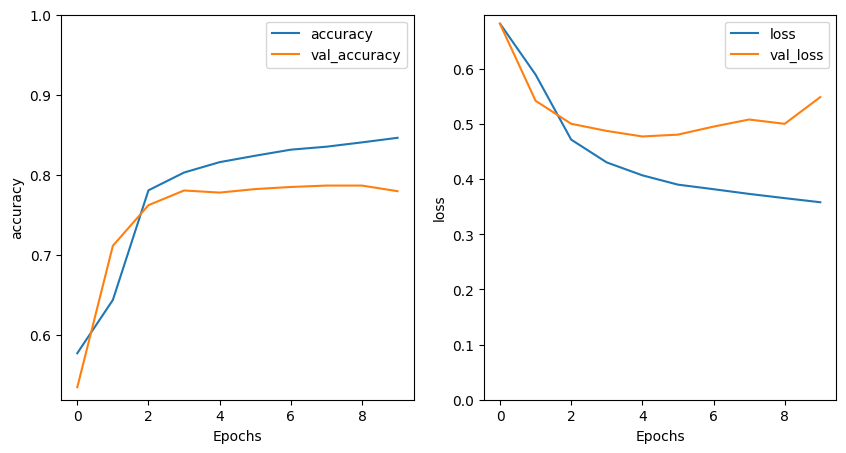

In [17]:
# since we have a pretty straightforward cake, we will leverage the sequential function and load in our array of ordered layers.


model_0 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
], name='model_lstm0')

model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history_0 = run_save_model(model_0,'model_lstm0',10, 30)


start time = 06/05/23:12:44:44
Epoch 1/10
203/203 [==============================] - 19s 48ms/step - loss: 0.6849 - accuracy: 0.5767 - val_loss: 0.6867 - val_accuracy: 0.5342
Epoch 2/10
203/203 [==============================] - 6s 27ms/step - loss: 0.6413 - accuracy: 0.5930 - val_loss: 0.5732 - val_accuracy: 0.6760
Epoch 3/10
203/203 [==============================] - 6s 28ms/step - loss: 0.4884 - accuracy: 0.7685 - val_loss: 0.5065 - val_accuracy: 0.7741
Epoch 4/10
203/203 [==============================] - 5s 26ms/step - loss: 0.4282 - accuracy: 0.8039 - val_loss: 0.4860 - val_accuracy: 0.7548
Epoch 5/10
203/203 [==============================] - 6s 30ms/step - loss: 0.4050 - accuracy: 0.8178 - val_loss: 0.4863 - val_accuracy: 0.7802
Epoch 6/10
203/203 [==============================] - 5s 26ms/step - loss: 0.3883 - accuracy: 0.8275 - val_loss: 0.4890 - val_accuracy: 0.7758
Epoch 7/10
203/203 [==============================] - 6s 28ms/step - loss: 0.3791 - accuracy: 0.8319 - val_los

start time = 06/05/23:12:46:42
102/102 [==============================] - 4s 7ms/step


<ipython-input-16-352dd3882e07>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['target'] = (model_obj.predict(test_text)>.5)*1


end time = 06/05/23:12:46:47
Saving Predictions


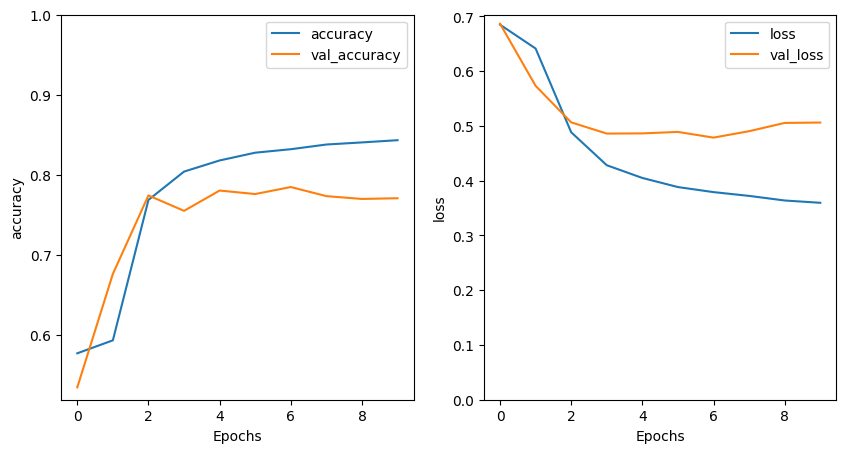

In [18]:
# since we have a pretty straightforward cake, we will leverage the sequential function and load in our array of ordered layers.


model_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
], name='model_gru0')

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history_1 = run_save_model(model_1,'model_gru0',10, 30)


### Review

So here we have our model using 2 different RNN related layers. The LSTM has a slightly lower accuracy. When we submit our results to kaggle, we see that this difference tracks. LTSM basic = 0.77414 vs GRU basic = 0.78026

## Step 4 : Results and Analysis

Based on our initial models, GRU has won. Let's continue on with the tf reference material and stack two RNN layers together. We will do this for LSTM and GRU. We will also add a dropout layer and change our encoding to product a tf-idf output. 

Dropout is when we randomly drop a subset of our data in order to reduce overfitting.

tf-idf is a way to normalize our text vectorized representation.

DISCLAIMER : We are. limited to 5 kaggle subissions per day, so we are not going to do more hyperparameter tunes than the ones listed above. 

start time = 06/05/23:12:46:48
Epoch 1/10
203/203 [==============================] - 35s 75ms/step - loss: 0.6840 - accuracy: 0.5767 - val_loss: 0.6869 - val_accuracy: 0.5342
Epoch 2/10
203/203 [==============================] - 11s 53ms/step - loss: 0.5978 - accuracy: 0.6469 - val_loss: 0.5498 - val_accuracy: 0.7128
Epoch 3/10
203/203 [==============================] - 10s 49ms/step - loss: 0.4850 - accuracy: 0.7779 - val_loss: 0.5173 - val_accuracy: 0.7347
Epoch 4/10
203/203 [==============================] - 11s 54ms/step - loss: 0.4451 - accuracy: 0.8031 - val_loss: 0.5101 - val_accuracy: 0.7601
Epoch 5/10
203/203 [==============================] - 11s 54ms/step - loss: 0.4206 - accuracy: 0.8186 - val_loss: 0.5043 - val_accuracy: 0.7680
Epoch 6/10
203/203 [==============================] - 11s 53ms/step - loss: 0.4039 - accuracy: 0.8280 - val_loss: 0.5349 - val_accuracy: 0.7583
Epoch 7/10
203/203 [==============================] - 10s 50ms/step - loss: 0.3931 - accuracy: 0.8354 - v

start time = 06/05/23:12:50:23
102/102 [==============================] - 6s 13ms/step
end time = 06/05/23:12:50:30
Saving Predictions


<ipython-input-16-352dd3882e07>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['target'] = (model_obj.predict(test_text)>.5)*1


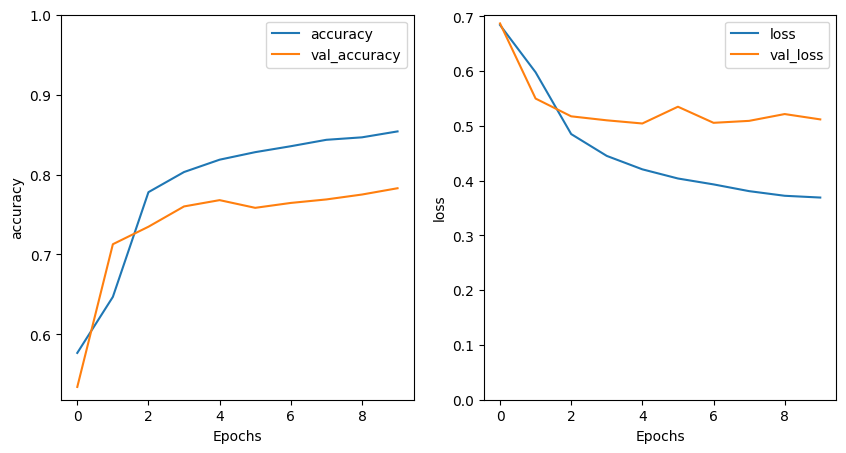

In [19]:
# since we have a pretty straightforward cake, we will leverage the sequential function and load in our array of ordered layers.


model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
], name='model_lstm1')

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history_2 = run_save_model(model_2,'model_lstm1',10, 30)


In [20]:
encoder3 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=2,
    output_mode='tf_idf',
)

encoder3.adapt(train_dataset.map(lambda text, label: text))


start time = 06/05/23:12:50:39
Epoch 1/10
203/203 [==============================] - 192s 893ms/step - loss: 0.6850 - accuracy: 0.5767 - val_loss: 0.6919 - val_accuracy: 0.5342
Epoch 2/10
203/203 [==============================] - 182s 898ms/step - loss: 0.6759 - accuracy: 0.5767 - val_loss: 0.6772 - val_accuracy: 0.5342
Epoch 3/10
203/203 [==============================] - 181s 893ms/step - loss: 0.6583 - accuracy: 0.5865 - val_loss: 0.6518 - val_accuracy: 0.5893
Epoch 4/10
203/203 [==============================] - 180s 888ms/step - loss: 0.6500 - accuracy: 0.6081 - val_loss: 0.6496 - val_accuracy: 0.5928
Epoch 5/10
203/203 [==============================] - 179s 882ms/step - loss: 0.6463 - accuracy: 0.6146 - val_loss: 0.6452 - val_accuracy: 0.5981
Epoch 6/10
203/203 [==============================] - 179s 880ms/step - loss: 0.6434 - accuracy: 0.6138 - val_loss: 0.6429 - val_accuracy: 0.6016
Epoch 7/10
203/203 [==============================] - 179s 884ms/step - loss: 0.6412 - accura

start time = 06/05/23:13:21:39
102/102 [==============================] - 26s 233ms/step
end time = 06/05/23:13:22:05
Saving Predictions


<ipython-input-16-352dd3882e07>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['target'] = (model_obj.predict(test_text)>.5)*1


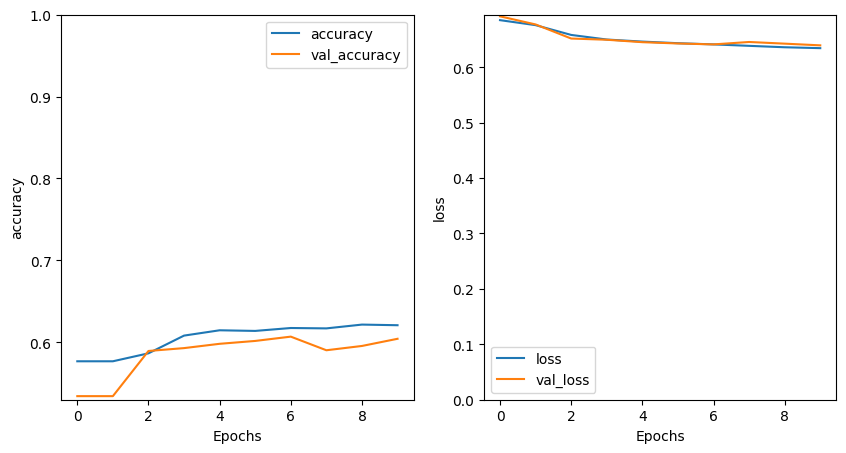

In [21]:
# since we have a pretty straightforward cake, we will leverage the sequential function and load in our array of ordered layers.


model_3 = tf.keras.Sequential([
    encoder3,
    tf.keras.layers.Embedding(len(encoder3.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
], name='model_gru1')

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history_3 = run_save_model(model_3,'model_gru1',10, 30)


### Analysis

Per the graphs about, some models have more variability in their scores as the epochs move along.

Also, adding tf_idf encoding and the second rnn layer improved the scores, but only slightly.

## Step 5 : Conclusion

If we were allowed more submission per day, I would have created more iterations with hyperparameter tunes. 


#### Learnings:
1. Training these models can take time!
2. Basic layerings can get "good" results
3. Layer combos impact score improvement more than hyper-parameters

#### What didn't work:
1. Adding a second LSTM layer
2. Adding dropout
3. tf-idf 

#### Ways to Improve:
1. Programatically train shallow models and make layers as we go
2. Add other text vectorization techniques
3. Make all this better using classes and functions. Basically, code up some wrappers for extensibility

In [ ]:
from google.colab import runtime
runtime.unassign()